In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import scgenmulti
from matplotlib import pyplot as plt
import umap
import seaborn as sns
import gc
import os
import tensorflow as tf

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Using TensorFlow backend.
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/97212545/anaconda3/envs/scanpygpu/

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config InlineBackend.figure_format='retina'

In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [5]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

# Load the Dataset

In [6]:
SCRNA_DIR = '../data/scRNA/'
SCATAC_DIR = '../data/scATAC/'

## scRNA

In [7]:
%time scrna = sc.read_h5ad(SCRNA_DIR + 'expressions.h5ad')
scrna = scrna[scrna.obs['condition'] == 'control']
scrna

CPU times: user 364 ms, sys: 1.22 s, total: 1.59 s
Wall time: 2.11 s


View of AnnData object with n_obs × n_vars = 35582 × 3000 
    obs: 'Group', 'nUMI_pre', 'nUMI', 'nGene', 'cell_type', 'Barcode', 'condition'
    var: 'gene_name', 'gene_id', 'exonLength', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Group_colors', 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_umap'

## scATAC

In [8]:
%time scatac = sc.read_h5ad(SCATAC_DIR + 'peaks.h5ad')
scatac = scatac[scatac.obs['condition'] == 'control']
scatac

CPU times: user 1.44 s, sys: 39.2 s, total: 40.7 s
Wall time: 44.9 s


View of AnnData object with n_obs × n_vars = 35038 × 20002 
    obs: 'FRIP', 'TotalReads', 'Group', 'Barcode', 'initialClusters', 'UMAP1', 'UMAP2', 'Clusters', 'cell_type', 'condition', 'nb_features', 'n_counts'
    var: 'score', 'scoreQuantile', 'name', 'GC', 'n_cells', 'prop_shared_cells', 'variability_score'
    uns: 'Group_colors', 'cell_type_colors', 'condition_colors'
    obsm: 'X_umap'

In [9]:
n_samples = min(scrna.shape[0], scatac.shape[0])
sample_indices = np.random.choice(range(n_samples), size=n_samples, replace=False)
scrna = scrna[sample_indices]
scatac = scatac[sample_indices]
print(scrna.shape, scatac.shape)

(35038, 3000) (35038, 20002)


# Train the model

In [10]:
network = scgenmulti.VAEArithKeras2([scrna.shape[1], scatac.shape[1]],
                                     h_dimension=800, z_dimension=50,
                                     learning_rate=0.0001, alpha=0.0001, beta=0, gamma=0.1)

Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0 (InputLayer)            (None, 3000)         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 20002)        0                                            
__________________________________________________________________________________________________
VAE_0 (Model)                   (None, 3000)         6143840     input_0[0][0]                    
__________________________________________________________________________________________________
VAE_1 (Model)                   (None, 20002)        33364042    input_1[0][0]                    
Total params: 39,507,882
Trainable params: 39,495,082
Non-trainable params: 12,800
_____________

In [11]:
history = network.train([scrna, scatac], n_epochs=50, batch_size=32, verbose=1)


Epoch 1/50
35038/35038 [==============================] - 78s 2ms/step - loss: 1027.3833 - VAE_0_loss: 229.9029 - VAE_1_loss: 797.4731 - VAE_0_recon_loss: 182.7016 - VAE_0_kl_loss: 150.8338 - VAE_0_cross_recon_loss: 471.8828 - VAE_1_recon_loss: 750.2746 - VAE_1_kl_loss: 150.8338 - VAE_1_cross_recon_loss: 471.8828
Epoch 2/50
35038/35038 [==============================] - 78s 2ms/step - loss: 955.6103 - VAE_0_loss: 196.0485 - VAE_1_loss: 759.5676 - VAE_0_recon_loss: 152.3123 - VAE_0_kl_loss: 186.6802 - VAE_0_cross_recon_loss: 437.1693 - VAE_1_recon_loss: 715.8264 - VAE_1_kl_loss: 186.6802 - VAE_1_cross_recon_loss: 437.1693
Epoch 3/50
35038/35038 [==============================] - 78s 2ms/step - loss: 943.2027 - VAE_0_loss: 190.1033 - VAE_1_loss: 753.0986 - VAE_0_recon_loss: 146.9783 - VAE_0_kl_loss: 201.5045 - VAE_0_cross_recon_loss: 431.0413 - VAE_1_recon_loss: 709.9751 - VAE_1_kl_loss: 201.5045 - VAE_1_cross_recon_loss: 431.0413
Epoch 4/50
35038/35038 [==============================] 

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


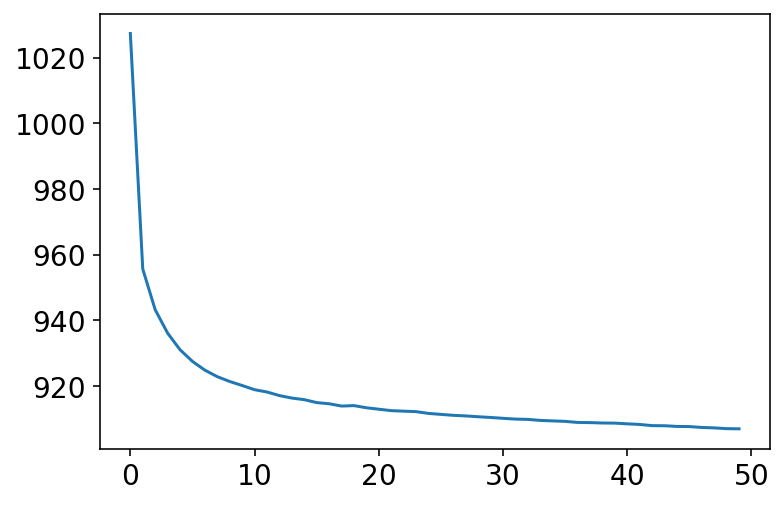

In [12]:
plt.plot(history.history['loss']);

# Visualization

## Latent space of scRNA-seq

In [13]:
scrna_latent = network.to_latent(scrna.X, 0)[0]
scrna_latent = sc.AnnData(scrna_latent)
scrna_latent.obs = scrna.obs

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anac

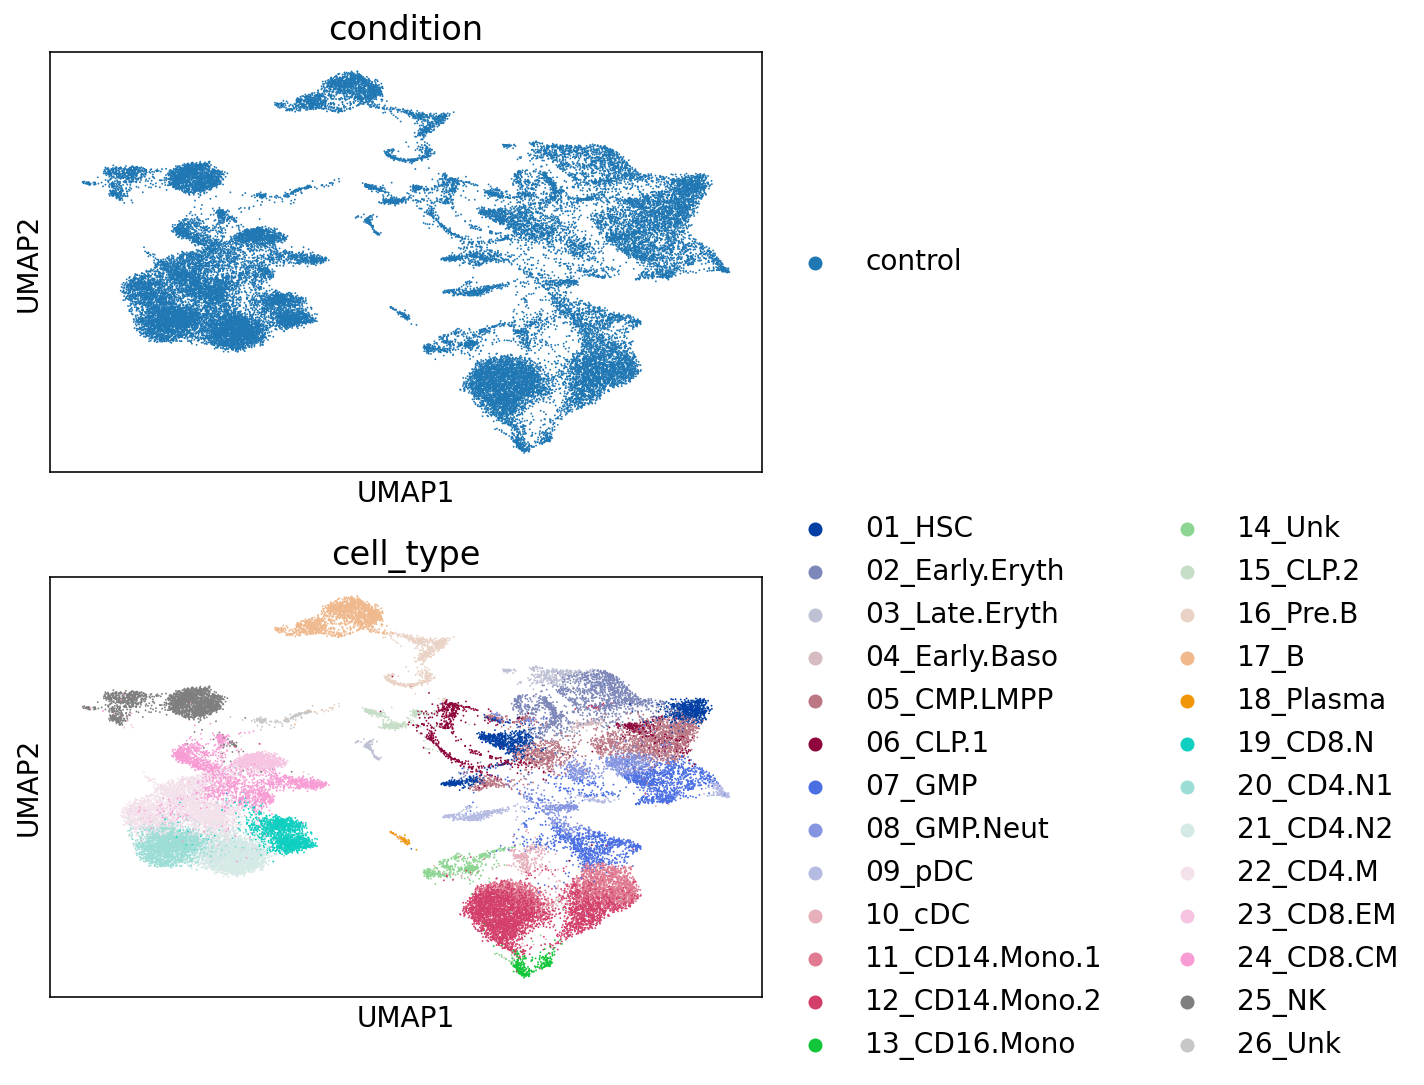

In [14]:
sc.pp.neighbors(scrna_latent, random_state=42)
sc.tl.umap(scrna_latent, random_state=42)
sc.pl.umap(scrna_latent, color=['condition', 'cell_type'], ncols=1)

## Latent space of scATAC-seq

In [15]:
scatac_latent = network.to_latent(scatac.X, 1)[0]
scatac_latent = sc.AnnData(scatac_latent)
scatac_latent.obs = scatac.obs

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


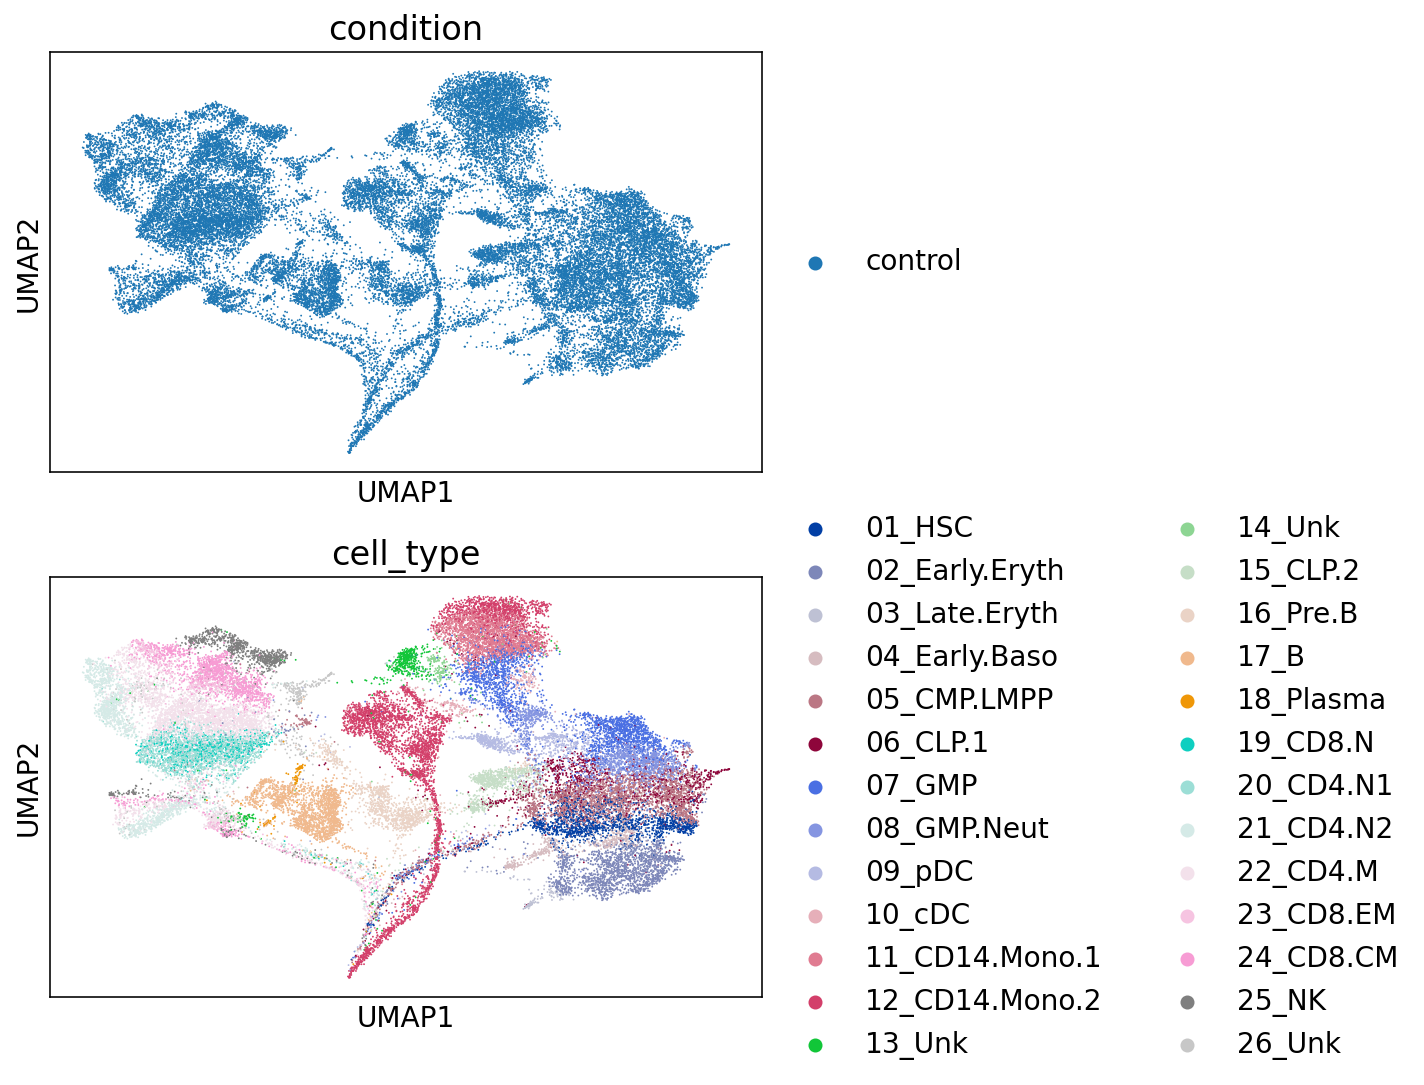

CPU times: user 1min 26s, sys: 2.39 s, total: 1min 28s
Wall time: 47.9 s


In [16]:
%%time
sc.pp.neighbors(scatac_latent, random_state=42)
sc.tl.umap(scatac_latent, random_state=42)
sc.pl.umap(scatac_latent, color=['condition', 'cell_type'], ncols=1)

## Latent space of both modalities

In [17]:
scall_latent = np.concatenate([scrna_latent.X, scatac_latent.X], axis=0)

scall_latent = sc.AnnData(scall_latent)
scrnaobs = scrna.obs
scatacobs = scatac.obs
scrnaobs['modality'] = 'scRNA-seq'
scatacobs['modality'] = 'scATAC-seq'

scall_latent.obs = pd.concat([scrnaobs, scatacobs])

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
... storing 'Group' as categorical
... storing 'cell_type' as categorical
... storing 'Barcode' as categorical
... storing 'modality' as categorical
... storing 'initialClusters' as categorical
... storing 'Clusters' as categorical


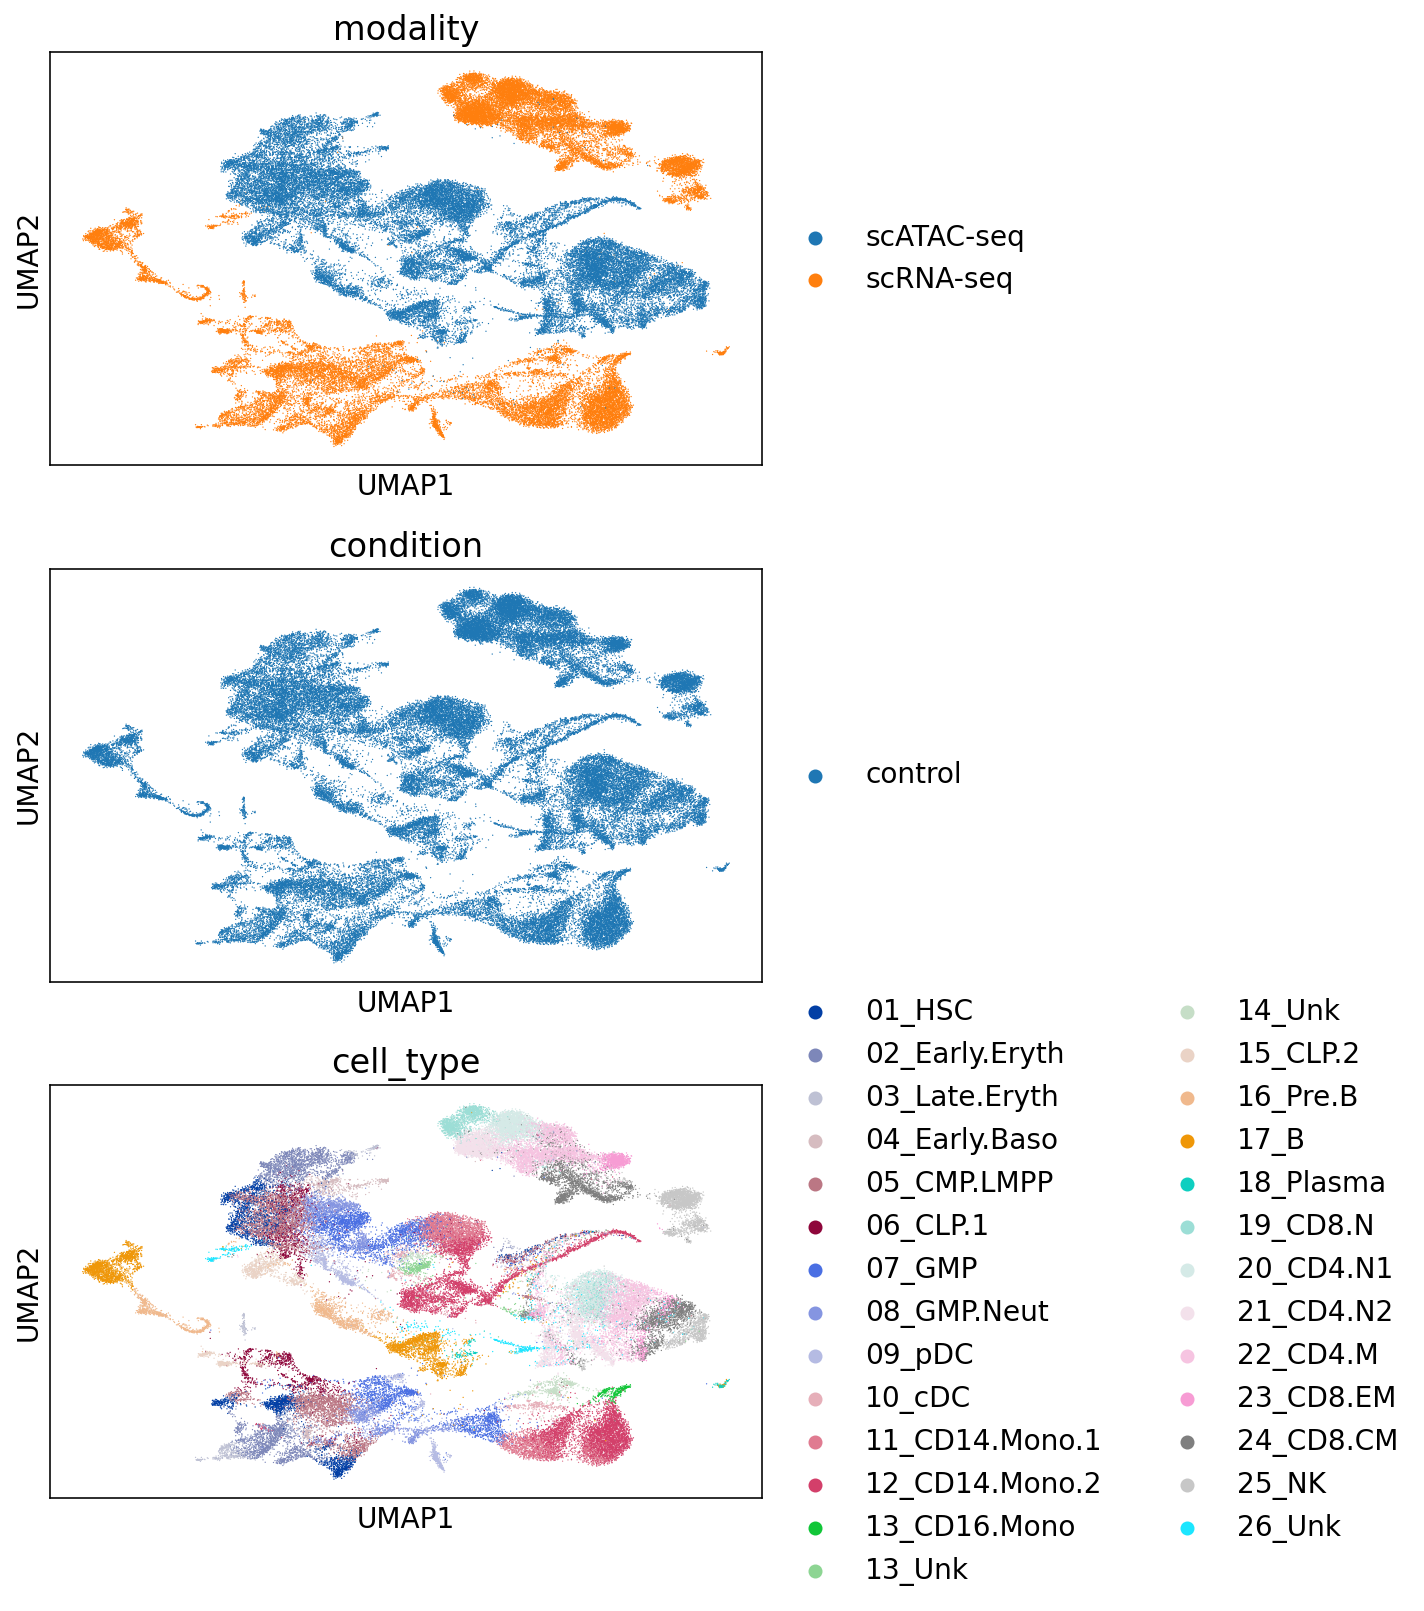

CPU times: user 4min 49s, sys: 7.73 s, total: 4min 57s
Wall time: 1min 46s


In [18]:
%%time
sc.pp.neighbors(scall_latent, random_state=42)
sc.tl.umap(scall_latent, random_state=42)
sc.pl.umap(scall_latent, color=['modality', 'condition', 'cell_type'], ncols=1)